<a href="https://colab.research.google.com/github/masher5764/COVID-19-mRNA-Vaccine-Degradation-Prediction-GCN-GRU-/blob/main/COVID_19_mRNA_Vaccine_Degradation_Prediction_GCN_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload files

Saving test.json to test.json


In [ ]:
import pandas as pd
import json

# Read the JSONL file and convert it to a DataFrame
json_data = []
with open('/content/train.json', 'r') as file:
    for line in file:
        json_data.append(json.loads(line))

# Create a DataFrame from the JSON data
train_df = pd.DataFrame(json_data)

# Save the DataFrame to a CSV file
train_df.to_csv('/content/train.csv', index=False)

print("Conversion complete! The file has been saved as train.csv.")


Conversion complete! The file has been saved as train.csv.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import ast

# Load the dataset
file_path = '/content/train.csv'  # Update the path to your dataset if different
data = pd.read_csv(file_path)

# Display the first few rows to verify
print(data.head())


   index            id                                           sequence  \
0      0  id_001f94081  GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...   
1      1  id_0049f53ba  GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...   
2      2  id_006f36f57  GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...   
3      3  id_0082d463b  GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...   
4      4  id_0087940f4  GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...   

                                           structure  \
0  .....((((((.......)))).)).((.....((..((((((......   
1  .....(((((((((((((((((((((((....)))))))))).)))...   
2  .....((((.((.....((((.(((.....)))..((((......)...   
3  ......((((((((((((((((......))))))))))))))))((...   
4  .....(((((((.((((((((((((.(((((((((....)))))))...   

                                 predicted_loop_type  signal_to_noise  \
0  EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...            6.894   
1  EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...  

In [ ]:
# List of columns that store array-like data as strings
array_columns = [
    "reactivity_error", "deg_error_Mg_pH10", "deg_error_pH10",
    "deg_error_Mg_50C", "deg_error_50C", "reactivity",
    "deg_Mg_pH10", "deg_pH10", "deg_Mg_50C", "deg_50C"
]

# Convert these columns to Python lists
for col in array_columns:
    data[col] = data[col].apply(ast.literal_eval)

# Verify the conversion by printing a sample column
print(data['reactivity_error'].head())


0    [0.1359, 0.207, 0.1633, 0.1452, 0.1314, 0.105,...
1    [2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...
2    [0.0931, 0.1329, 0.1128, 0.0891, 0.0844, 0.080...
3    [3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...
4    [1.665, 2.1728, 2.0041, 1.2405, 0.6202, 1.4981...
Name: reactivity_error, dtype: object


In [ ]:
# Retain only rows with a signal-to-noise ratio greater than 1
filtered_data = data[data["signal_to_noise"] > 1]

# Verify the size of the filtered dataset
print(f"Filtered dataset size: {filtered_data.shape}")

Filtered dataset size: (2096, 19)


In [ ]:
# Define a mapping for encoding
token2int = {x: i for i, x in enumerate("().ACGUBEHIMSX")}

# Function to encode sequences
def encode_sequence(df, cols=["sequence", "structure", "predicted_loop_type"]):
    encoded = np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )
    return encoded

# Apply encoding to the filtered dataset
encoded_inputs = encode_sequence(filtered_data)

# Check the shape of the encoded data
print(f"Encoded input shape: {encoded_inputs.shape}")


Encoded input shape: (2096, 107, 3)


<ipython-input-36-abdcd5708244>:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda seq: [token2int[x] for x in seq])


In [ ]:
# Function to process RNA structure and create adjacency matrix
def get_couples(structure):
    opened = [idx for idx, i in enumerate(structure) if i == '(']
    closed = [idx for idx, i in enumerate(structure) if i == ')']
    assert len(opened) == len(closed)

    assigned = []
    couples = []
    for close_idx in closed:
        for open_idx in opened:
            if open_idx < close_idx and open_idx not in assigned:
                assigned.append(open_idx)
                couples.append([open_idx, close_idx])
                break
    return couples

def build_matrix(couples, size):
    mat = np.zeros((size, size))
    for i in range(size):
        if i < size - 1:
            mat[i, i + 1] = 1
        if i > 0:
            mat[i, i - 1] = 1
    for i, j in couples:
        mat[i, j] = 1
        mat[j, i] = 1
    return mat

def convert_to_adj(structure):
    couples = get_couples(structure)
    return build_matrix(couples, len(structure))

# Apply adjacency matrix generation to the dataset
adj_matrix = np.array(filtered_data["structure"].apply(convert_to_adj).tolist())

# Check the shape of the adjacency matrix
print(f"Adjacency matrix shape: {adj_matrix.shape}")

Adjacency matrix shape: (2096, 107, 107)


In [ ]:
import torch

# Convert inputs and adjacency matrix to tensors
train_inputs = torch.tensor(encoded_inputs, dtype=torch.long)
train_adj = torch.tensor(adj_matrix, dtype=torch.float32)

# Prepare labels (target outputs) as tensors
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
train_labels = torch.tensor(
    np.array(filtered_data[pred_cols].values.tolist()).transpose((0, 2, 1)),
    dtype=torch.float32
)

# Print shapes to confirm
print(f"Input tensor shape: {train_inputs.shape}")
print(f"Adjacency tensor shape: {train_adj.shape}")
print(f"Labels tensor shape: {train_labels.shape}")


Input tensor shape: torch.Size([2096, 107, 3])
Adjacency tensor shape: torch.Size([2096, 107, 107])
Labels tensor shape: torch.Size([2096, 68, 5])


In [ ]:
class AverageMeter:
    """
    Computes and stores the average and current value
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [ ]:
from torch.utils.data import random_split, DataLoader, TensorDataset

# Combine inputs, adjacency matrices, and labels into a dataset
dataset = TensorDataset(train_inputs, train_adj, train_labels)

# Split the dataset into training and validation sets (e.g., 80% train, 20% valid)
train_size = int(0.8 * len(dataset))  # 80% for training
valid_size = len(dataset) - train_size  # Remaining for validation
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
# Verify DataLoader by iterating through a batch
for inputs, adj, labels in train_loader:
    print(f"Inputs shape: {inputs.shape}")
    print(f"Adjacency shape: {adj.shape}")
    print(f"Labels shape: {labels.shape}")
    break

Inputs shape: torch.Size([64, 107, 3])
Adjacency shape: torch.Size([64, 107, 107])
Labels shape: torch.Size([64, 68, 5])


In [ ]:
import torch.nn as nn

class GCN(nn.Module):
    """
    A single GCN layer that aggregates features from neighbors.
    """
    def __init__(self, input_dim, output_dim, aggregator='mean'):
        super(GCN, self).__init__()
        self.aggregator = aggregator

        # Adjust the input dimensions based on the aggregator type
        if aggregator == 'mean':
            linear_input_dim = input_dim * 2
        elif aggregator == 'conv':
            linear_input_dim = input_dim
        elif aggregator == 'pooling':
            linear_input_dim = input_dim * 2
            self.linear_pooling = nn.Linear(input_dim, input_dim)
        elif aggregator == 'lstm':
            self.lstm_hidden = 128
            linear_input_dim = input_dim + self.lstm_hidden
            self.lstm_agg = nn.LSTM(input_dim, self.lstm_hidden, num_layers=1, batch_first=True)

        # Define the linear layer for the GCN
        self.linear_gcn = nn.Linear(in_features=linear_input_dim, out_features=output_dim)

    def forward(self, input_, adj_matrix):
        """
        Forward pass for GCN layer.
        """
        adj_matrix = adj_matrix.type(torch.float32)
        sum_adj = torch.sum(adj_matrix, axis=2)
        sum_adj[sum_adj == 0] = 1  # Avoid division by zero

        if self.aggregator == 'mean' or self.aggregator == 'conv':
            feature_agg = torch.bmm(adj_matrix, input_)
            feature_agg = feature_agg / sum_adj.unsqueeze(dim=2)

        elif self.aggregator == 'pooling':
            feature_pooling = self.linear_pooling(input_)
            feature_agg = torch.sigmoid(feature_pooling)
            feature_agg = torch.bmm(adj_matrix, feature_agg)
            feature_agg = feature_agg / sum_adj.unsqueeze(dim=2)

        elif self.aggregator == 'lstm':
            feature_agg = torch.zeros(input_.shape[0], input_.shape[1], self.lstm_hidden).cuda()
            for i in range(adj_matrix.shape[1]):
                neighbors = adj_matrix[:, i, :].unsqueeze(2) * input_
                _, hn = self.lstm_agg(neighbors)
                feature_agg[:, i, :] = torch.squeeze(hn[0], 0)

        # Concatenate features
        if self.aggregator != 'conv':
            feature_cat = torch.cat((input_, feature_agg), axis=2)
        else:
            feature_cat = feature_agg

        # Apply linear transformation and normalize
        feature = torch.sigmoid(self.linear_gcn(feature_cat))
        feature = feature / torch.norm(feature, p=2, dim=2).unsqueeze(dim=2)

        return feature

In [ ]:
# Define device as CPU
device = torch.device("cpu")

In [ ]:
class Net(nn.Module):
    def __init__(self, num_embedding=14, seq_len=107, pred_len=68, dropout=0.5,
                 embed_dim=100, hidden_dim=128, K=1, aggregator='mean'):
        """
        K: Number of GCN layers.
        aggregator: Type of GCN aggregator function.
        """
        super(Net, self).__init__()

        self.pred_len = pred_len

        # Embedding layer
        self.embedding_layer = nn.Embedding(num_embeddings=num_embedding, embedding_dim=embed_dim)

        # GCN layers
        self.gcn = nn.ModuleList([GCN(3 * embed_dim, 3 * embed_dim, aggregator=aggregator) for _ in range(K)])

        # GRU layer
        self.gru_layer = nn.GRU(input_size=3 * embed_dim, hidden_size=hidden_dim, num_layers=3,
                                batch_first=True, dropout=dropout, bidirectional=True)

        # Linear layer
        self.linear_layer = nn.Linear(in_features=2 * hidden_dim, out_features=5)

    def forward(self, input_, adj_matrix):
        # Embedding
        embedding = self.embedding_layer(input_)
        embedding = torch.reshape(embedding, (-1, embedding.shape[1], embedding.shape[2] * embedding.shape[3]))

        # GCN
        gcn_feature = embedding
        for gcn_layer in self.gcn:
            gcn_feature = gcn_layer(gcn_feature, adj_matrix)

        # GRU
        gru_output, _ = self.gru_layer(gcn_feature)
        truncated = gru_output[:, :self.pred_len]

        # Linear layer
        output = self.linear_layer(truncated)

        return output

In [ ]:
def train_fn(epoch, model, train_loader, criterion, optimizer):
    model.train()
    model.zero_grad()
    train_loss = AverageMeter()

    for input_, adj, label in train_loader:
        input_ = input_.to(device)
        adj = adj.to(device)
        label = label.to(device)

        preds = model(input_, adj)
        loss = criterion(preds, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.update(loss.item())

    print(f"Train Loss: {train_loss.avg}")
    return train_loss.avg


In [ ]:
def eval_fn(epoch, model, valid_loader, criterion):
    model.eval()
    eval_loss = AverageMeter()

    with torch.no_grad():
        for input_, adj, label in valid_loader:
            input_ = input_.to(device)
            adj = adj.to(device)
            label = label.to(device)

            preds = model(input_, adj)
            loss = criterion(preds, label)
            eval_loss.update(loss.item())

    print(f"Valid Loss: {eval_loss.avg}")
    return eval_loss.avg


In [ ]:
model = Net(K=1, aggregator='mean')
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses, eval_losses = [], []

for epoch in range(10):  # Adjust number of epochs
    print(f"Epoch {epoch + 1}/{10}")
    train_loss = train_fn(epoch, model, train_loader, criterion, optimizer)
    eval_loss = eval_fn(epoch, model, valid_loader, criterion)
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)

Epoch 1/10
Train Loss: 0.2469474916104917
Valid Loss: 0.19332158352647508
Epoch 2/10
Train Loss: 0.17877936528788674
Valid Loss: 0.16862872881548746
Epoch 3/10
Train Loss: 0.15993786189291212
Valid Loss: 0.1554375077996935
Epoch 4/10
Train Loss: 0.1454152321373975
Valid Loss: 0.1402831311736788
Epoch 5/10
Train Loss: 0.13237473727376373
Valid Loss: 0.12956792967660086
Epoch 6/10
Train Loss: 0.1267659012918119
Valid Loss: 0.1273754302944456
Epoch 7/10
Train Loss: 0.12373263885577519
Valid Loss: 0.12069197744131088
Epoch 8/10
Train Loss: 0.11941195720875705
Valid Loss: 0.12262801293815885
Epoch 9/10
Train Loss: 0.11739867649696491
Valid Loss: 0.11541217246225902
Epoch 10/10
Train Loss: 0.1118029546406534
Valid Loss: 0.11195164706025805


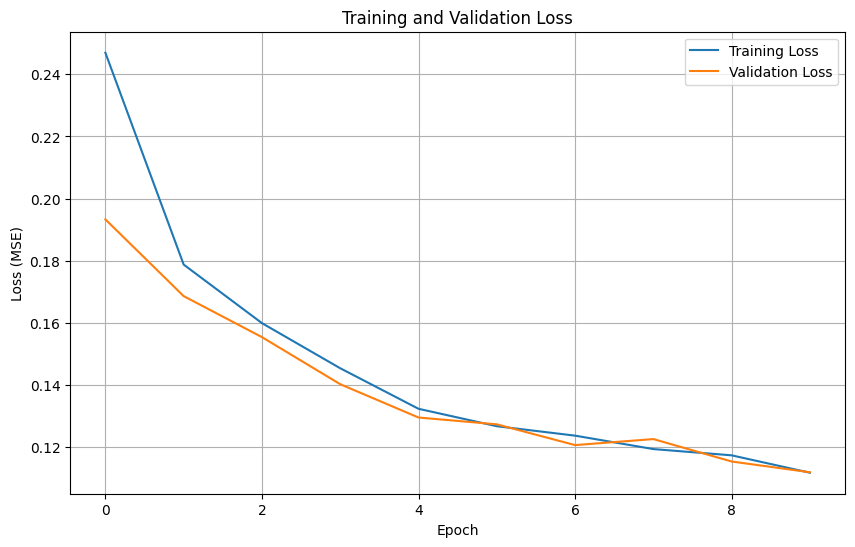

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import pandas as pd
import json

# Read the JSONL file and convert it to a DataFrame
json_data = []
with open('/content/test.json', 'r') as file:
    for line in file:
        json_data.append(json.loads(line))

# Create a DataFrame from the JSON data
test_df = pd.DataFrame(json_data)

# Save the DataFrame to a CSV file
test_df.to_csv('/content/test.csv', index=False)

print("Conversion complete! The file has been saved as test.csv.")

In [ ]:
def encode_sequence(df, cols=["sequence", "structure", "predicted_loop_type"]):
    """
    Encodes the sequence, structure, and predicted_loop_type columns into numerical format.
    Handles sequences of varying lengths by padding with a special token.
    """
    token2int = {x: i for i, x in enumerate("().ACGUBEHIMSX")}

    # Find maximum sequence length
    max_len = max(df[cols[0]].str.len().max(), df[cols[1]].str.len().max(), df[cols[2]].str.len().max())

    # Pad sequences to ensure consistent length
    encoded_cols = []
    for col in cols:
        encoded_col = df[col].apply(lambda seq: [token2int[x] for x in seq] + [0] * (max_len - len(seq))).tolist()
        encoded_cols.append(encoded_col)

    # Stack the encoded columns
    encoded = np.stack(
        [np.array(col) for col in encoded_cols],
        axis=-1
    )
    return encoded

import numpy as np

def pad_matrices(matrices, max_len):
    """Pads adjacency matrices to a uniform size."""
    padded_matrices = []
    for matrix in matrices:
        pad_width = max_len - matrix.shape[0]
        if pad_width > 0:
            padded_matrix = np.pad(matrix, ((0, pad_width), (0, pad_width)), 'constant')
        else:
            padded_matrix = matrix  # No padding needed
        padded_matrices.append(padded_matrix)
    return padded_matrices

def preprocess_inputs(df):
    """
    Preprocesses the test dataset by encoding sequences and generating adjacency matrices.
    """
    # Encode sequences
    inputs = encode_sequence(df)

    # Generate adjacency matrices and find max dimension
    adj_matrices = df["structure"].apply(convert_to_adj).tolist()
    max_len = max(matrix.shape[0] for matrix in adj_matrices)  # Get max dimension

    # Pad matrices to uniform size
    adj_matrices = pad_matrices(adj_matrices, max_len)

    adj_matrices = np.array(adj_matrices) # Now convert to numpy array
    return inputs, adj_matrices


In [ ]:

# Load test dataset
test_file_path = '/content/test.csv'  # Update path if needed
test_df = pd.read_csv(test_file_path)

# Preprocess test dataset: encode sequences and create adjacency matrices
test_inputs, test_adj = preprocess_inputs(test_df)

# Convert to PyTorch tensors
test_inputs = torch.tensor(test_inputs, dtype=torch.long)
test_adj = torch.tensor(test_adj, dtype=torch.float32)

# Create a DataLoader for the test set
test_dataset = TensorDataset(test_inputs, test_adj)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to predict on test set
def predict_fn(model, test_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for input_, adj in test_loader:
            input_ = input_.to(device)
            adj = adj.to(device)

            preds = model(input_, adj)  # Forward pass
            predictions.append(preds.cpu().numpy())  # Collect predictions as numpy arrays

    # Concatenate all predictions into a single array
    return np.concatenate(predictions, axis=0)

# Run predictions
test_predictions = predict_fn(model, test_loader)

# Flatten predictions by averaging over sequence positions (dim=1)
test_predictions_flat = test_predictions.mean(axis=1)  # Shape: (3634, 5)

# Convert predictions into a dataframe for saving
test_pred_df = pd.DataFrame(test_predictions_flat, columns=['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C'])

# Add IDs if present in the test dataset
if 'id' in test_df.columns:
    test_pred_df['id'] = test_df['id']

# Save predictions to a CSV file
output_file_path = '/content/test_predictions.csv'
test_pred_df.to_csv(output_file_path, index=False)
print(f"Predictions saved to {output_file_path}")

Predictions saved to /content/test_predictions.csv


In [ ]:
df = pd.read_csv('/content/test_predictions.csv')
print(df.head())

   reactivity  deg_Mg_pH10  deg_pH10  deg_Mg_50C   deg_50C            id
0    0.431237     0.483657  0.443725    0.424505  0.409333  id_00073f8be
1    0.469506     0.538078  0.461687    0.463949  0.438194  id_000ae4237
2    0.437343     0.467953  0.464754    0.468155  0.451226  id_00131c573
3    0.304229     0.385591  0.395364    0.315947  0.306997  id_00181fd34
4    0.145027     0.237169  0.199008    0.120045  0.090763  id_0020473f7
